# Treatment for Malocclusion. Alexey Nepochatov. HSE 2022.

# Task description 
In this assignment you are going to analyse scull measurement data of patients with malocclusion. Patients affected by Class III malocclusion (characterised by the protrusion of lower dental arch) suffer from a skeletal imbalance that is established early in life, and that becomes more pronounced during puberty and until skeletal maturation is complete. Predicting treatment success or failure early in a single Class III patient makes it easier to correct it, but it is difficult to do just from a small number of morphometric determinants is problematic. The reason for that is that Class III malocclusion is rarely a consequence of an abnormality in a single craniofacial component, so individual clinical and radiological measurements are likely to be less indicative than the interplay between the measurements themselves.

The data set we will use contains 143 patients with two sets of measurements at ages T1 and T2 (measured in years) for the following variables:

- **Treatment**: untreated (0) or treated (1).
- **Growth**: a binary variable with values Good or Bad, determined on the basis of CoGn-CoA.
- **ANB**: angle between Down's points A and B (degrees).
- **IMPA**: incisor-mandibular plane angle (degrees).
- **PPPM**: palatal plane - mandibular plane angle (degrees).
- **CoA**: total maxillary length from condilion to Down's point A (mm).
- **GoPg**: length of mandibular body from gonion to pogonion (mm).
- **CoGo**: length of mandibular ramus from condilion to pogonion (mm).

All the measurements are taken from x-ray scans using a set of reference points established using a map.

For simplicity, we transform the dataset by taking differences between time points T2 and T1, so all features now represent changes in measurements.

We would like to estimate the effect of the treatment on Growth and dANB by taking into account causal relationships between variables. 


Treatment assignment, Growth and number of years between two measurements are likely to be affected by some unobserved confounders, as the graph shows. 

Given the graph, select the variables to condition on, apply suitable adjustment method, and calculate your estimates of causal effects: Treatment on Growth, Treatment on dANB, both ATE and ATET.


Analysis should contain:

* Selection of covariates to adjust for (informed by the graph)
* Application of the most suitable adjustment method
* Estimates of the ATE and ATET

In [1]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import statsmodels.api as sm
import networkx as nx
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from causalinference import CausalModel

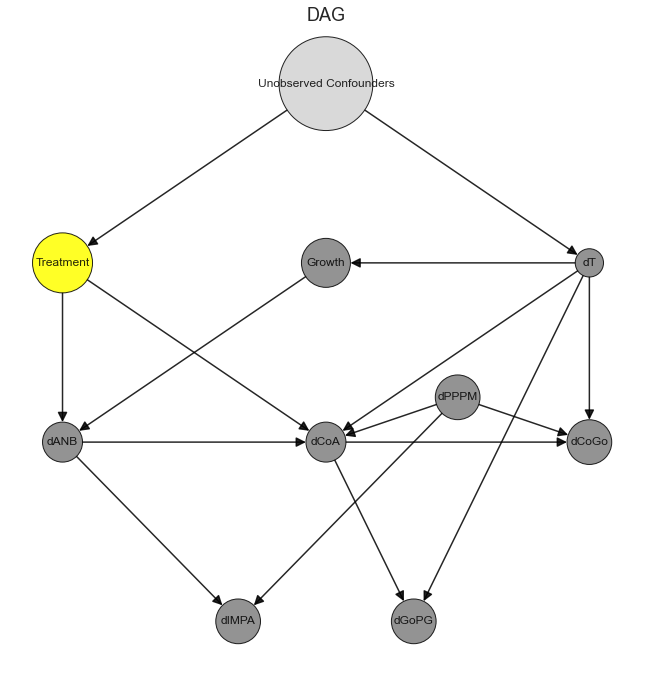

In [9]:
G = nx.DiGraph(directed=True, strict=True)

# for graph plot
x_max = 1
y_max = 1

G.add_node("Treatment", pos=( -x_max, 0), color='yellow')
G.add_node('Growth', pos = (0, 0), color='grey')
G.add_node('dANB', pos = (-x_max, -y_max), color='grey')
G.add_node('dIMPA', pos = (-x_max/3, -2*y_max), color='grey')
G.add_node('dPPPM', pos = (2*x_max/4, -3*y_max/4), color= 'grey')
G.add_node('dCoA', pos = (0, -y_max), color='grey')
G.add_node('dGoPG', pos = (x_max/3, -2*y_max), color='grey')
G.add_node('dCoGo', pos =  (x_max, -y_max), color='grey')
G.add_node('dT', pos = (x_max, 0), color = 'grey')
G.add_node('Unobserved Confounders', pos = (0, y_max), color='lightgrey')

G.add_edges_from(
    [('Unobserved Confounders', 'Treatment'),
     ('Unobserved Confounders', 'dT'), 
     ('Growth', 'dANB'),
     ('dANB', 'dIMPA'), 
     ('dANB', 'dCoA'), 
     ('Treatment', 'dANB'), 
     ('Treatment', 'dCoA'), 
     ('dCoA', 'dCoGo'), 
     ('dCoA', 'dGoPG'),
     ('dT', 'Growth'),
     ('dT', 'dCoA'), 
     ('dT', 'dCoGo'), 
     ('dT', 'dGoPG'), 
     ('dPPPM', 'dCoGo'), 
     ('dPPPM', 'dIMPA'),
     ('dPPPM', 'dCoA')]
)

color_node = nx.get_node_attributes(G, 'color')
color = [color_node[i] for i in G.nodes()]

fig, ax = plt.subplots(figsize=(10,10))
fig.tight_layout()
ax.set_title("DAG")
nx.draw(G, 
        pos=nx.get_node_attributes(G, 'pos'), 
        with_labels=True, 
        arrows=True,
        alpha=0.85,
        node_size=[len(v) * 400 for v in G.nodes()],
        width=1.5,
        arrowstyle='-|>',
        arrowsize=20,
        font_size=12,
        node_color=color,
        edgecolors="black",
        edge_color="black")

In [10]:
data = pd.read_csv('malocclusion.csv', sep=',')
data.head(10)

,dANB,dPPPM,dIMPA,dCoA,dGoPg,dCoGo,dT,Growth,Treatment
0,-3.2,-1.1,-4.2,1.0,4.0,3.7,5,0,0
1,-0.6,-0.5,3.8,2.6,-0.1,1.4,3,1,0
2,-1.6,-3.1,-6.0,4.3,4.2,7.1,5,0,0
3,-1.1,-2.1,-12.1,14.1,20.7,17.5,9,0,0
4,-1.1,0.0,-6.7,7.7,8.8,11.0,5,0,0
5,-0.6,-0.9,-1.1,0.1,-1.0,0.9,3,1,0
6,-1.2,-1.8,1.8,1.6,1.7,3.0,3,1,0
7,-0.1,-2.3,1.6,2.5,4.1,0.1,2,1,0
8,0.6,-0.9,0.6,5.1,5.1,8.7,3,0,1
9,-3.0,-2.6,0.4,11.9,14.7,16.5,11,0,0


In [11]:
data.describe()

,dANB,dPPPM,dIMPA,dCoA,dGoPg,dCoGo,dT,Growth,Treatment
count,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000
mean,-0.227273,-1.374825,-0.785315,5.987413,7.730769,6.732867,4.706294,0.405594,0.461538
std,1.826225,2.715046,5.080894,4.469692,5.532417,4.595141,2.550427,0.492733,0.500271
min,-5.100000,-9.300000,-19.000000,-0.900000,-1.400000,-2.600000,1.000000,0.000000,0.000000
25%,-1.350000,-2.750000,-3.450000,1.800000,3.200000,3.050000,3.000000,0.000000,0.000000
50%,-0.300000,-1.400000,-0.400000,5.500000,6.200000,6.300000,4.000000,0.000000,0.000000
75%,0.950000,0.050000,2.100000,9.750000,12.750000,10.350000,6.000000,1.000000,1.000000
max,4.900000,6.500000,12.000000,20.000000,23.300000,17.500000,12.000000,1.000000,1.000000


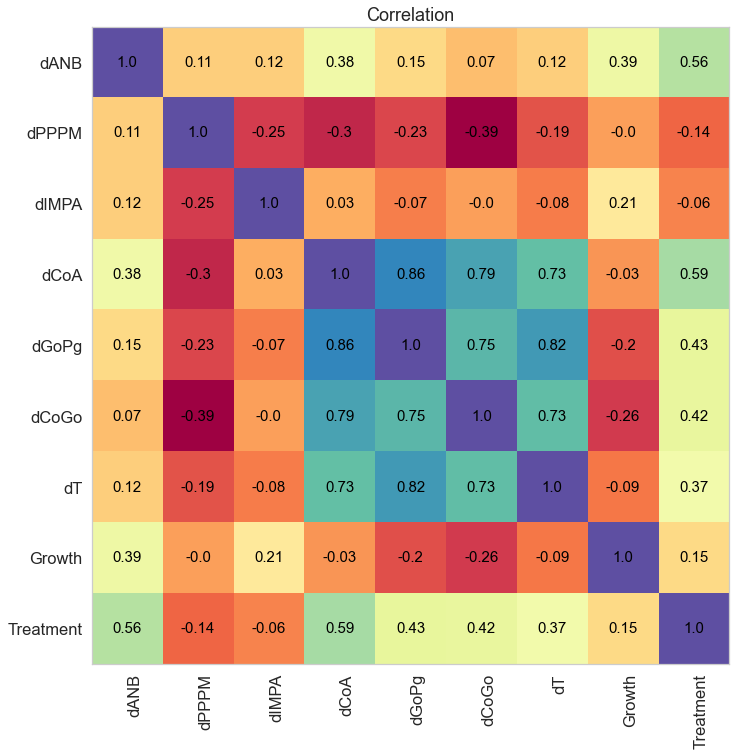

In [12]:
correlation = data.corr(method='pearson')
columns = data.columns.to_list()
n = len(columns)

fig, ax = plt.subplots(figsize=(10,10))
fig.tight_layout()
ax.imshow(correlation, cmap='Spectral')
ax.set_title("Correlation")
ax.grid(visible=None)
ax.set_xticks(np.arange(n))
ax.set_yticks(np.arange(n))
ax.set_xticklabels(columns)
ax.set_yticklabels(columns)

plt.setp(ax.get_xticklabels(), ha="right", rotation=90, rotation_mode="anchor")

for i in range(n):
    for j in range(n):
        text = ax.text(j, i, round(correlation[columns[i]][columns[j]], 2), ha="center", va="center", color="black", size = 15)

## Part I. Estimates of causal effects: Treatment on Growth.
### 1.1. Selection of covariates to adjust for (informed by the graph) (Treatment on Growth).

There is no edge or directed path from **Treatment** to **Growth** on the DAG, so we can assume that there is no relationship between them.

Let's look closer to find out if there is a causal effect between these variables or not.

We have only one non-direct back-door path from **Treatment** to **Growth**:
<br>**Treatment**  <-  Unobserved Confounders  ->  dT  ->  **Growth**

All other paths from **Treatment** to **Growth** are are blocked by the colliders. So we can control only **dT**, but if we do this, then we will block the very effect we want to estimate, thus biasing our estimates. Our model **violate the backdoor criterion** (Pearl, 2009a), which excludes controls that are descendants of the treatment along paths to the outcome.

The only way out for us is to try to use the **front-door criterion**. 
As was said in lectures we can enrich our graph with proxy variable that stands between **Treatment** and the outcome **Growth**.

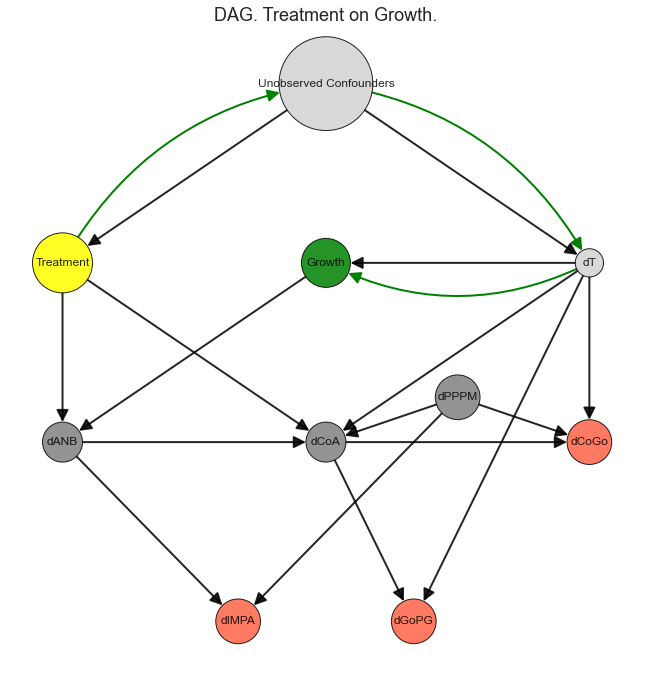

In [13]:
G = nx.DiGraph(directed=True, strict=True)

# for graph plot
x_max = 1
y_max = 1

G.add_node("Treatment", pos=( -x_max, 0), color='yellow', shape='s')
G.add_node('Growth', pos = (0, 0), color='green', shape='s')
G.add_node('dANB', pos = (-x_max, -y_max), color='grey', shape='s')
G.add_node('dIMPA', pos = (-x_max/3, -2*y_max), color='tomato', shape='s')
G.add_node('dPPPM', pos = (2*x_max/4, -3*y_max/4), color= 'grey', shape='s')
G.add_node('dCoA', pos = (0, -y_max), color='grey', shape='s')
G.add_node('dGoPG', pos = (x_max/3, -2*y_max), color='tomato', shape='s')
G.add_node('dCoGo', pos =  (x_max, -y_max), color='tomato', shape='s')
G.add_node('dT', pos = (x_max, 0), color = 'lightgrey', shape='s')
G.add_node('Unobserved Confounders', pos = (0, y_max), color='lightgrey', shape='v')

G.add_edges_from(
    [('Unobserved Confounders', 'Treatment'),
     ('Unobserved Confounders', 'dT'), 
     ('Growth', 'dANB'),
     ('dANB', 'dIMPA'), 
     ('dANB', 'dCoA'), 
     ('Treatment', 'dANB'), 
     ('Treatment', 'dCoA'), 
     ('dCoA', 'dCoGo'), 
     ('dCoA', 'dGoPG'),
     ('dT', 'Growth'),
     ('dT', 'dCoA'), 
     ('dT', 'dCoGo'), 
     ('dT', 'dGoPG'), 
     ('dPPPM', 'dCoGo'), 
     ('dPPPM', 'dIMPA'),
     ('dPPPM', 'dCoA')]
)

color_node = nx.get_node_attributes(G, 'color')
color = [color_node[i] for i in G.nodes()]

fig, ax = plt.subplots(figsize=(10,10))
fig.tight_layout()
ax.set_title("DAG. Treatment on Growth.")
nx.draw(G, 
        pos=nx.get_node_attributes(G, 'pos'), 
        node_shape='o',
        with_labels=True, 
        alpha=0.85,
        node_size=[len(v) * 400 for v in G.nodes()],
        width=2,
        arrowsize=25,
        font_size=12,
        node_color=color,
        edgecolors="black",
        edge_color="black")



path = [('Treatment','Unobserved Confounders'),
        ('Unobserved Confounders', 'dT'), 
        ('dT', 'Growth')
       ]

nx.draw_networkx_edges(G, 
                       pos=nx.get_node_attributes(G, 'pos'), 
                       arrowsize=25,
                       width=2,
                       edgelist=path,
                       edge_color="green",
                       node_size=[len(v) * 400 for v in G.nodes()],
                       connectionstyle=f'arc3, rad = -0.25');

In [11]:
# pip install causalgraphicalmodels
# pip install graphviz

Let's use a special library **CausalGraphicalModel** for graphs with **unobserved confounders** to validate what we write above

https://github.com/ijmbarr/notes-on-causal-inference/blob/master/causal-inference-2-causal-graphical-models.ipynb

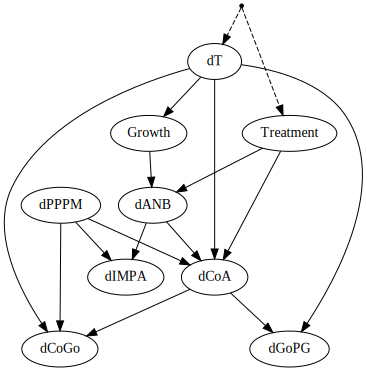

In [15]:
from causalgraphicalmodels import CausalGraphicalModel


nodes = ["Treatment", 
       'Growth',
       'dANB',
       'dIMPA', 
       'dPPPM', 
       'dCoA', 
       'dGoPG',
       'dCoGo',
       'dT']
#        'Unobserved Confounders']

edges = [('Growth', 'dANB'),
         ('dANB', 'dIMPA'), 
         ('dANB', 'dCoA'), 
         ('Treatment', 'dANB'), 
         ('Treatment', 'dCoA'), 
         ('dCoA', 'dCoGo'), 
         ('dCoA', 'dGoPG'),
         ('dT', 'Growth'),
         ('dT', 'dCoA'), 
         ('dT', 'dCoGo'), 
         ('dT', 'dGoPG'), 
         ('dPPPM', 'dCoGo'), 
         ('dPPPM', 'dIMPA'),
         ('dPPPM', 'dCoA')]

latent_edges = [('dT', 'Treatment')]

system_with_hidden_confounder = CausalGraphicalModel(
    nodes=nodes,
    edges=edges,
    latent_edges=latent_edges
)

system_with_hidden_confounder.draw()

Now let's check that if we choose **{dT}** as the adjustment set, then **Treatment** and **Growth** when conditioning on **dT** will be **d-separated**, that is, they will become **independent**

In [18]:
system_with_hidden_confounder.is_d_separated("Treatment", "Growth", {'dT'})

True

Let's use the naive method and see what it shows us. We've just shown that we can't directly use the back-door adjustment formula, but **just for curiosity**, let's see what it gives us.

In [14]:
ATE_adjusment_formula = data.Growth[data.Treatment == 1].mean() - data.Growth[data.Treatment == 0].mean()
ATE_adjusment_formula

0.1471861471861472

The result indicates a very weak effect of the Treatment on the Growth, but since we have additional confaounders and mediators in our DAG, this result can be highly biased.

### 1.2. Application of the most suitable adjustment method (Treatment on Growth).

In the lectures it was said that when we have a  **unobserved confounders** on the path, then we can use the **front-door criterion**. Let's see what we will get using the **front-door criterion**. As a proxy variable we may choose **dCoA**, it satisfies all three criteria according to the definition.

**Deﬁnition of Front-Door**: A set of variables Z is said to satisfy the front-door criterion relative to an ordered pair of variables(X, Y) if:
* Z intercepts all directed paths from X to Y. (In our case we have no such path, so YES)
* There is no unblocked path from X to Z. (Also Yes)
* All backdoor paths from Z to Y are blocked by X. (Yes, we have one path, which now is blocked by Treatment)


In [15]:
"""
Method implementation taken from here:
https://github.com/ijmbarr/notes-on-causal-inference/blob/master/causal-inference-3-frontdoor-adjustment.ipynb
"""

def estimate_ate_frontdoor_linear(df, x, y, z):
    """
    Estiamte the ATE of a system from a dataframe of samples `df`
    using frontdoor adjustment and assuming linear models.
    
    Arguments
    ---------
    df: pandas.DataFrame
    x: str
    y: str
    z: str
    
    Returns 
    -------
    ATE: float
    """
    x = df[x].values
    y = df[y].values
    z = df[z].values
    
    z_x_model = sm.OLS(z, sm.add_constant(x)).fit()
    
    z_bar = z_x_model.predict(sm.add_constant(x))
    z_prime = z - z_bar

    y_z_model = sm.OLS(y, sm.add_constant(z_prime)).fit()

    return y_z_model.params[1] * z_x_model.params[1]

In [16]:
ATE_front_door = round(estimate_ate_frontdoor_linear(data, 'Treatment', 'Growth', 'dCoA'), 3)
ATE_front_door

-0.103

### 1.3. Estimates of the ATE and ATET (Treatment on Growth).

We see that even with using front-door criterion we obtain **ATE** of Treatment on Growth very small，as we will show further, this is not comparable with the influence of the Treatment on dAND. This is consistent with what we wrote at the beginning that there is **no relationship** or **very weak relationship** between **Treatment** and **Growth**. Therefore, we can say that ATE and ATET are equal to zero。

## Part II. Estimates of causal effects: Treatment on dANB.
### 2.1. Selection of covariates to adjust for (informed by the graph) (Treatment on dANB).

Let's now estimating of causal effect **Treatment** on **dANB**. As we can see from the DAG we have a directed casual path from Treatment to dANB and one back-door path:
* **Treatment** <- Unobserved Confounders -> dT -> Growth -> **dANB**

Other paths from are blocked by colliders.

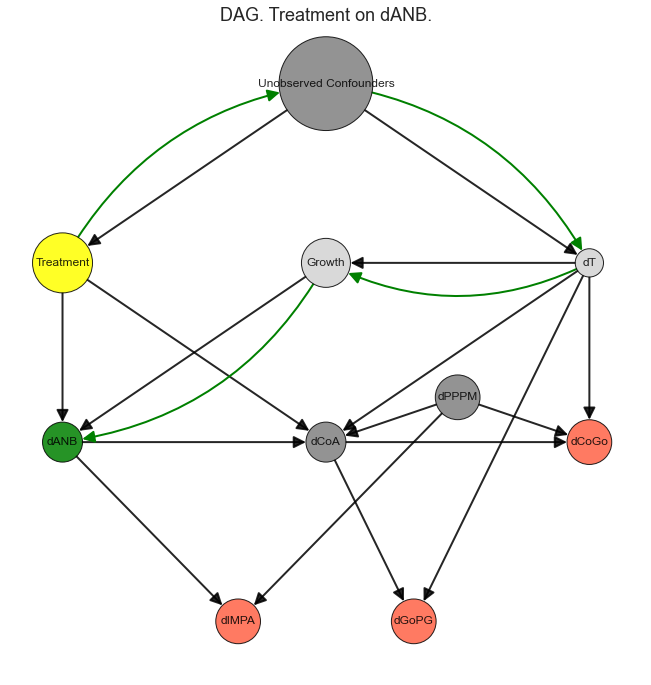

In [80]:
G = nx.DiGraph(directed=True, strict=True)

# for graph plot
x_max = 1
y_max = 1

G.add_node("Treatment", pos=( -x_max, 0), color='yellow')
G.add_node('Growth', pos = (0, 0), color='lightgrey')
G.add_node('dANB', pos = (-x_max, -y_max), color='green')
G.add_node('dIMPA', pos = (-x_max/3, -2*y_max), color='tomato')
G.add_node('dPPPM', pos = (2*x_max/4, -3*y_max/4), color= 'grey')
G.add_node('dCoA', pos = (0, -y_max), color='grey')
G.add_node('dGoPG', pos = (x_max/3, -2*y_max), color='tomato')
G.add_node('dCoGo', pos =  (x_max, -y_max), color='tomato')
G.add_node('dT', pos = (x_max, 0), color = 'lightgrey')
G.add_node('Unobserved Confounders', pos = (0, y_max), color='grey')

G.add_edges_from(
    [('Unobserved Confounders', 'Treatment'),
     ('Unobserved Confounders', 'dT'), 
     ('Growth', 'dANB'),
     ('dANB', 'dIMPA'), 
     ('dANB', 'dCoA'), 
     ('Treatment', 'dANB'), 
     ('Treatment', 'dCoA'), 
     ('dCoA', 'dCoGo'), 
     ('dCoA', 'dGoPG'),
     ('dT', 'Growth'),
     ('dT', 'dCoA'), 
     ('dT', 'dCoGo'), 
     ('dT', 'dGoPG'), 
     ('dPPPM', 'dCoGo'), 
     ('dPPPM', 'dIMPA'),
     ('dPPPM', 'dCoA')]
)

color_node = nx.get_node_attributes(G, 'color')
color = [color_node[i] for i in G.nodes()]

fig, ax = plt.subplots(figsize=(10,10))
fig.tight_layout()
ax.set_title("DAG. Treatment on dANB.")
nx.draw(G, 
        pos=nx.get_node_attributes(G, 'pos'), 
        node_shape='o',
        with_labels=True, 
        alpha=0.85,
        node_size=[len(v) * 400 for v in G.nodes()],
        width=2,
        arrowsize=25,
        font_size=12,
        node_color=color,
        edgecolors="black",
        edge_color="black")



path_1 = [('Treatment', "Unobserved Confounders"),
        ("Unobserved Confounders", "dT"), 
        ("dT", "Growth"),
        ("Growth","dANB")
       ]

nx.draw_networkx_edges(G, 
                       pos=nx.get_node_attributes(G, 'pos'), 
                       arrowsize=25,
                       width=2,
                       edgelist=path_1,
                       edge_color="green",
                       node_size=[len(v) * 400 for v in G.nodes()],
                       connectionstyle=f'arc3, rad = -0.25');

As we can see from the DAG, in order to satisfy the back-door criteria, we need to block the back-door path, and we can do it by controlling **dT**, **Growth** or both of them.


But when choosing a adjustment set, we also need to take into account the **problem of multicollinearity** and a fairly small number of observations. We would also like to use linear regression, it requires the linearity of the model, therefore, based on these considerations, we should choose adjustment set from one feature. But for the sake of interest, we will also see what happens if we include **dT**, **Growth** into the adjustment set.

In [71]:
# Linear Regression on Treatment, Growth and dT

m = smf.ols('dANB ~ Treatment + Growth + dT', data=data)
fitted = m.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                   dANB   R-squared:                       0.409
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     32.12
Date:                Fri, 28 Oct 2022   Prob (F-statistic):           7.78e-16
Time:                        12:48:05   Log-Likelihood:                -250.87
No. Observations:                 143   AIC:                             509.7
Df Residuals:                     139   BIC:                             521.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.4021      0.276     -5.075      0.0

### 2.2. Application of the most suitable adjustment method (Treatment on dANB).

We see that the coefficient in front of **dT** is almost zero (-0,038), so we will build a model using adjusment set **{Growth}**, , controlling for **Growth** blocks the back-door path from **Treatment** to **dANB** due to the unobserved confounder U, and produces an unbiased estimate of the ATE.

In [72]:
# Linear Regression on Treatment and Growth.

m = smf.ols('dANB ~ Treatment + Growth', data=data)
fitted = m.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                   dANB   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     48.04
Date:                Fri, 28 Oct 2022   Prob (F-statistic):           1.31e-16
Time:                        12:48:06   Log-Likelihood:                -251.17
No. Observations:                 143   AIC:                             508.3
Df Residuals:                     140   BIC:                             517.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.5600      0.181     -8.609      0.0

$ATE_{LR} = 1.856$

$CI_{LR} = [1.381, 2.331]$

### Propensity score weighting (Treatment on dANB)

A simple way to estimate ATE is to calculate the difference of weighted means between treated and control groups. A slightly more smart way would be to pass these weights to the regression function – this way we'd also get p-value and confidence interval automatically. Notice we're using wls (weighted least squares) instead of the ols (ordinary least squares)

In [73]:
# classifier to estimate the propensity score
cls = LogisticRegression()

# calibration of the classifier
cls = CalibratedClassifierCV(cls)

X = data[['Growth']]
y = data['Treatment']
cls.fit(X, y)

data['e'] = cls.predict_proba(X)[:,1].tolist()
data.head()

,dANB,dPPPM,dIMPA,dCoA,dGoPg,dCoGo,dT,Growth,Treatment,e
0,-3.2,-1.1,-4.2,1.0,4.0,3.7,5,0,0,0.34318
1,-0.6,-0.5,3.8,2.6,-0.1,1.4,3,1,0,0.42124
2,-1.6,-3.1,-6.0,4.3,4.2,7.1,5,0,0,0.34318
3,-1.1,-2.1,-12.1,14.1,20.7,17.5,9,0,0,0.34318
4,-1.1,0.0,-6.7,7.7,8.8,11.0,5,0,0,0.34318


In [74]:
data['w'] = data['Treatment'] / data['e'] + (1 - data['Treatment']) / (1 - data['e'])

In [75]:
m = smf.wls('dANB ~ Treatment + Growth', data=data, weights=data['w'])
fitted = m.fit()
print(fitted.summary())

                            WLS Regression Results                            
Dep. Variable:                   dANB   R-squared:                       0.386
Model:                            WLS   Adj. R-squared:                  0.378
Method:                 Least Squares   F-statistic:                     44.06
Date:                Fri, 28 Oct 2022   Prob (F-statistic):           1.44e-15
Time:                        12:48:15   Log-Likelihood:                -253.68
No. Observations:                 143   AIC:                             513.4
Df Residuals:                     140   BIC:                             522.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.5572      0.205     -7.609      0.0

$ATE_{PSW} = 1.857$

$CI_{PSW} = [1.380, 2.334]$

### Doubly Robust Estimator (Treatment on dANB)

To build doubly robust estimator, we'd need two additional linear regression models, each using features from the selected adjustment set (which contains only age in this case and not proteinuria).

In [76]:
y0 = LinearRegression().fit(data[data.Treatment == 0][['Growth']], data[data.Treatment == 0]['dANB']).predict(data[['Growth']])
y1 = LinearRegression().fit(data[data.Treatment == 1][['Growth']], data[data.Treatment == 1]['dANB']).predict(data[['Growth']])

data['DR0'] = (1-data['Treatment']) * (data['dANB'] - y0)/(1-data['e']) + y0
data['DR1'] =    data['Treatment']  * (data['dANB'] - y1)/   data['e']  + y1

In [77]:
ATE_DRE_T_on_dANB = data['DR1'].mean() - data['DR0'].mean()

print(f"ATE Doubly Robust = %.3f" % ATE_DRE_T_on_dANB)

ATE Doubly Robust = 1.856


We wull use a **bootstrap method** to estimate the confidence interval of the ATE.
An external library https://pypi.org/project/bootstrap-stat/ actually has more exciting bootstrap methods implemented, including BCa bootstrap! The library is rather new and fresh, but seems to be working fine!

In [78]:
from bootstrap_stat import bootstrap_stat as bp

delta = []

for i in range(5000):
    cls = LogisticRegression()
    cls = CalibratedClassifierCV(cls)
    
    sample = data.sample(frac=1, replace = True).reset_index(drop=True)
    X = sample[['Growth']]
    y = sample['Treatment']
    
    cls.fit(X, y)

    sample['e'] = cls.predict_proba(X)[:,1].tolist()
    sample['w'] = sample['Treatment'] / sample['e'] + (1 - sample['Treatment']) / (1 - sample['e'])
    
    y0 = LinearRegression().fit(sample[sample.Treatment == 0][['Growth']], sample[sample.Treatment == 0]['dANB']).predict(sample[['Growth']])
    y1 = LinearRegression().fit(sample[sample.Treatment == 1][['Growth']], sample[sample.Treatment == 1]['dANB']).predict(sample[['Growth']])
    
    sample['DR0'] = (1-sample['Treatment']) * (sample['dANB'] - y0)/(1-sample['e']) + y0
    sample['DR1'] =    sample['Treatment']  * (sample['dANB'] - y1)/   sample['e']  + y1

    delta.append(sample['DR1'].mean() - sample['DR0'].mean())                     

print('ATE Doubly Robust BTS =', round(np.mean(delta), 3))
print("CI Doubly Robust =", bp.bcanon_interval(bp.EmpiricalDistribution(delta), np.median, delta, B=5000))

ATE Doubly Robust BTS = 1.859
CI Doubly Robust = (1.85354237546792, 1.8675655751316036)


### Matching with Mahalanobis distance  (Treatment on dANB).

In [63]:
adjustment_set = ['Growth']

causal = CausalModel(
    Y=data['dANB'].values, # outcome
    D=data['Treatment'].values, # treatment
    X=data[adjustment_set].values
)

causal.est_via_matching(bias_adj=True)
print(causal.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      1.856      0.237      7.829      0.000      1.392      2.321
           ATC      1.860      0.240      7.761      0.000      1.390      2.330
           ATT      1.852      0.240      7.723      0.000      1.382      2.322



### Propensity score matching (Treatment on dANB).

In [48]:
causal = CausalModel(
    Y=data['dANB'].values, # outcome
    D=data['Treatment'].values, # treatment
    X=data['e'].values
)
causal.est_via_matching(bias_adj=True)
print(causal.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      1.856      0.237      7.829      0.000      1.392      2.321
           ATC      1.860      0.240      7.761      0.000      1.390      2.330
           ATT      1.852      0.240      7.723      0.000      1.382      2.322



## 2.3. Estimates of the ATE and ATET (Treatment on dANB).

* We have considered several methods, such as **Linear Regression**, **Doubly Robust Estimator**, **Mahalanobis distance**, **Propensity score** and can see that they give a similar answer for **ATE**. So we can choose Doubly Robust Estimator as our method.
<br> **ATE = 1.856** with Confidence Interval [1.853, 1.867] 

* We also considered two methods for calculating ATET: **Mahalanobis distance**, and **Propensity score** and they give similar answers for **ATET**.  
<br> **ATET = 1.852** with Confidence Interval [1.382, 2.322]